In [1]:
N_sample = 1000 # number of samples to keep from each chain

## imports

In [2]:
import lenstronomy

lenstronomy.__version__

'1.9.1'

In [3]:
import numpy as np
import os
import pickle
import copy
import time
import h5py
from pprint import pprint
import joblib
import gc

from lenstronomy.Util import util
from lenstronomy.Util import param_util
from lenstronomy.Workflow.fitting_sequence import FittingSequence
from lenstronomy.Plots.model_plot import ModelPlot
from lenstronomy.Plots import chain_plot
from lenstronomy.Sampling.parameters import Param
#from lenstronomy.Analysis.lens_analysis import LensAnalysis
from lenstronomy.Util import mask_util
from lenstronomy.LensModel.lens_model import LensModel
from lenstronomy.Data.coord_transforms import Coordinates
from lenstronomy.Util.util import array2image

import paperfig as pf
pf.set_fontscale(2.)

cwd = os.getcwd()
base_path, _ = os.path.split(cwd)
print('Base directory path:', base_path)

Base directory path: /Users/ajshajib/Research/time_delay_cosmography/J2038/WGD2038-4008/lenstronomy_modeling


In [4]:
gc.collect()

20

## functions

In [5]:
savefig = True

In [6]:
import sys
sys.path.insert(0, './process_output')

# load necessary functions for BIC computation and unpickling composite model outputs
from output_class import *

# load output files

## load composite model chains and process

In [7]:
composite_files = [
    '2038_run205_1_0_0_0_0_shortened',
    '2038_run205_1_0_1_0_0_shortened',
    '2038_run205_1_0_2_0_0_shortened',
    '2038_run205_1_1_0_0_0_shortened',
    '2038_run205_1_1_1_0_0_shortened',
    '2038_run205_1_1_2_0_0_shortened',
    
    '2038_run206_1_0_0_0_0_shortened',
    '2038_run206_1_0_1_0_0_shortened',
    '2038_run206_1_0_2_0_0_shortened',
    '2038_run206_1_1_0_0_0_shortened',
    '2038_run206_1_1_1_0_0_shortened',
    '2038_run206_1_1_2_0_0_shortened',
    
]


def custom_loglikelihood_addition(kwargs_lens=None, kwargs_source=None, 
                                 kwargs_lens_light=None, kwargs_ps=None, 
                                 kwargs_special=None, kwargs_extinction=None):
    """
    Impose a Gaussian prior on the NFW scale radius R_s based on Gavazzi et al. (2007).
    """
    # imports inside function to avoid pickling 
    from colossus.halo import concentration
    from colossus.halo import mass_defs
    from colossus.cosmology import cosmology
    
    from lenstronomy.Cosmo.lens_cosmo import LensCosmo
    from lenstronomy.Analysis.lens_profile import LensProfileAnalysis
    from lenstronomy.LensModel.lens_model import LensModel


    lens_cosmo = LensCosmo(z_lens=0.230, z_source=0.777)
    lens_analysis = LensProfileAnalysis(
                            LensModel(lens_model_list=['NFW_ELLIPSE', 'SHEAR', 'TRIPLE_CHAMELEON'],
                            z_lens=0.230, z_source=0.777,
                            multi_plane=False, #True,
                            ))


    if kwargs_lens[0]['alpha_Rs'] < 0.:
        return -np.inf
    
    if not -0.014271818911080656-0.2 < kwargs_lens[0]['center_x'] < -0.014271818911080656+0.2:
        return -np.inf
    if not -0.020882886550870693-0.2 < kwargs_lens[0]['center_y'] < -0.020882886550870693+0.2:
        return -np.inf
    
    if not -0.5 < kwargs_lens[0]['e1'] < 0.5:
        return -np.inf
    if not -0.5 < kwargs_lens[0]['e2'] < 0.5:
        return -np.inf
    
    log_L = 0.
    
    # integrate upto 3.2 arcsec, which is half-light radius (~half-mass radius)
    mean_convergence = lens_analysis.mass_fraction_within_radius(kwargs_lens, 
                                                             kwargs_lens[2]['center_x'], 
                                                             kwargs_lens[2]['center_y'], 
                                                             3.2,
                                                             numPix=320)
    
    stellar_mass = np.log10(mean_convergence[2] * np.pi * (3.2/206265 * lens_cosmo.dd)**2 
                            * lens_cosmo.sigma_crit * 2) # multiplying by 2 to convert half-mass to full mass
    
    #log_L += - 0.5 * (stellar_mass - 11.40)**2 / (0.08**2 + 0.1**2)
    # adding 0.07 uncertainty in quadrature to account for 15% uncertainty in H_0, Om_0 ~ U(0.05, 0.5)
    high_sm = 11.57 + 0.25 + 0.06 # +0.06 is to add H_0 uncertainty
    low_sm = 11.57 - 0.06 # -0.06 is to add H_0 uncertainty
    if stellar_mass > high_sm:
        log_L += -0.5 * (high_sm - stellar_mass)**2 / (0.16**2)
    elif stellar_mass < low_sm:
        log_L += -0.5 * (low_sm - stellar_mass)**2 / (0.13**2)
    else:
        log_L += 0.
        
    _, _, c, r, halo_mass = lens_cosmo.nfw_angle2physical(kwargs_lens[0]['Rs'], kwargs_lens[0]['alpha_Rs'])
    log_L += -0.5 * (np.log10(halo_mass) - 13.5)**2 / 0.3**2
    
    my_cosmo = {'flat': True, 'H0': 70., 'Om0': 0.3, 'Ob0': 0.05, 
                'sigma8': 0.823, 'ns': 0.96} # fiducial cosmo
    cosmo = cosmology.setCosmology('my_cosmo', my_cosmo)

    c200 = concentration.concentration(halo_mass*cosmo.h, '200c', # input halo mass needs to be in M_sun/h unit
                                       0.23, model='diemer19')
    
    log_L += -0.5 * (np.log10(c) - np.log10(c200))**2 / (0.11**2)
            
    return log_L

In [8]:
composite_bics = []
composite_param_arrays = []
composite_num_param_arrays = []
composite_kwargs_models = []
composite_kwargs_constraints = []
composite_param_classes = []
composite_lens_models = []
composite_kwargs_likelihoods = []
composite_multi_band_list = []

for job_name_out in composite_files:
    output_temp = os.path.join(base_path, 'temp', job_name_out +'_out.txt')

    f = open(output_temp, 'rb')
    [input_, output_] = joblib.load(f)
    f.close()
    fitting_kwargs_list, kwargs_joint, kwargs_model, kwargs_constraints, kwargs_likelihood, kwargs_params, init_samples = input_
    
    kwargs_result, multi_band_list_out, fit_output, _ = output_
    multi_band_list = kwargs_joint['multi_band_list']

    samples_mcmc = fit_output[-1][1] #[np.random.randint(0, high=fit_output[-1][1].shape[0], size=N_sample)]
    param_mcmc = fit_output[-1][2]

    param_class = Param(kwargs_model,
                        kwargs_params['lens_model'][2], 
                        kwargs_params['source_model'][2],
                        kwargs_params['lens_light_model'][2],
                        kwargs_params['point_source_model'][2],
                        kwargs_lens_init=kwargs_params['lens_model'][0], #kwargs_result['kwargs_lens'],
                        **kwargs_constraints
                       )
    
    lens_model = LensModel(lens_model_list=kwargs_model['lens_model_list'],
                           z_lens=0.230, z_source=0.777,
                           multi_plane=False, #True, 
                          )
    
    num_data = np.sum([np.sum(m) for m in kwargs_likelihood['image_likelihood_mask_list']])
    num_param = param_class.num_param()[0] + param_class.num_param_linear()
    max_logL = np.max(fit_output[-1][-1])
    
    bic = compute_BIC(num_data, num_param, max_logL)
    
    composite_bics.append(bic)
    composite_param_arrays.append(np.copy(samples_mcmc))
    composite_num_param_arrays.append(len(samples_mcmc))
    composite_kwargs_models.append(kwargs_model)
    composite_kwargs_constraints.append(kwargs_constraints)
    composite_param_classes.append(param_class)
    composite_lens_models.append(lens_model)
    composite_kwargs_likelihoods.append(kwargs_likelihood)
    composite_multi_band_list.append(multi_band_list_out)
    
    gc.collect()
    #break

In [9]:
# composite parameter numbers
for param_class in composite_param_classes:
    print('non-linear: {}, linear: {}'.format(param_class.num_param()[0], param_class.num_param_linear()))

non-linear: 54, linear: 206
non-linear: 54, linear: 241
non-linear: 54, linear: 279
non-linear: 54, linear: 206
non-linear: 54, linear: 241
non-linear: 54, linear: 279
non-linear: 54, linear: 206
non-linear: 54, linear: 241
non-linear: 54, linear: 279
non-linear: 54, linear: 206
non-linear: 54, linear: 241
non-linear: 54, linear: 279


In [10]:
PHOTMODE = 'WFC3 IR F160W'      # / Observing confi                                
PHOTFLAM =  1.9275602E-20       # / Inverse sensitivity, ergs/cm2/A/e-             
PHOTFNU  =  1.5187570E-07       # / Inverse sensitivity, Jy*sec/e-                 
PHOTZPT  = -2.1100000E+01       # / ST magnitude zero point                        
PHOTPLAM =  1.5369176E+04       # / Pivot wavelength (Angstroms)                   
PHOTBW   =  8.2625085E+02       # / RMS bandwidth of filter plus detector


def get_stmag(electron_flux, photflam, photzpt):
    flux = np.asarray(electron_flux)
    scalar_input = False
    if flux.ndim == 0:
        flux = flux[None]  
        scalar_input = True
  
    flux = flux * photflam
    mag = -2.5 * np.log10(flux) + photzpt
  
    if scalar_input:
        return np.squeeze(mag)
 
    return mag

def get_abmag(flux, photflam, photzpt, photplam):
    stmag = get_stmag(flux, photflam, photzpt)
    
    return stmag - 5. * np.log10(photplam) + 2.5 * np.log10(299792458e10) - 27.5

In [11]:
from astropy.cosmology import FlatLambdaCDM
from lenstronomy.Cosmo.lens_cosmo import LensCosmo

cosmo = FlatLambdaCDM(H0=70, Om0=0.3)
lens_cosmo = LensCosmo(0.230, 0.777)

D_d = cosmo.angular_diameter_distance(0.230).value

D_d, lens_cosmo.sigma_crit

(757.8805471249445, 3236777839592540.5)

In [12]:
import lenstronomy.Util.class_creator as class_creator
from lenstronomy.LightModel.light_model import LightModel
from lenstronomy.Util import mask_util as mask_util
import lenstronomy.Util.util as util


composite_theta_es = []
composite_gammas = []

composite_gamma_exts = []
composite_psi_exts = []
composite_qs = []
composite_phis = []
composite_reffs = []

composite_dphi_ABs = []
composite_dphi_ACs = []
composite_dphi_ADs = []

composite_invariant_gradients = []

composite_del_bics = np.max(composite_bics) - np.array(composite_bics) 
sigma_numeric_bic, sigma_model_bic = 99.91711718678918, 325.16992966107614
composite_weights = get_relative_weights(composite_bics, sigma_numeric_bic, take_std=False, 
                                  sigma_model=sigma_model_bic)

#composite_weights = [1.] * len(composite_lens_models)
composite_Rs = []
composite_kappa_0s = []
composite_mass2lights = []

#print(composite_weights)

for n_job in tnrange(len(composite_files), desc='Jobs:'):
    
    composite_theta_e = []
    composite_theta_e_precision = []
    composite_gamma = []
    composite_gamma_ext = []
    composite_psi_ext = []
    composite_reff = []

    composite_dphi_AB = []
    composite_dphi_AC = []
    composite_dphi_AD = []
    
    composite_invariant_gradient = []
    composite_mass2light = []
    
    num_sample_from_job = int(composite_weights[n_job] * N_sample) #composite_num_param_arrays[n_job])
    
    td_cosmography = TDCosmography(z_lens=0.230, z_source=0.777, kwargs_model=composite_kwargs_models[n_job])
    
    lens_model = composite_lens_models[n_job] #lens_analysis.LensModel
    lens_analysis = LensProfileAnalysis(composite_lens_models[n_job])
    param_class = composite_param_classes[n_job]
    
    sampled_indices = []
    bad_indices = []
    
    light_model = LightModel(kwargs_model['lens_light_model_list'])
    x_grid, y_grid = util.make_grid(numPix=200, deltapix=0.005)
    #mask = mask_util.mask_azimuthal(x_grid, y_grid, center_x, center_y, theta_E)
    
    while len(sampled_indices) < num_sample_from_job:
        if len(sampled_indices) + len(bad_indices) >= composite_num_param_arrays[n_job]:
            print(len(sampled_indices), len(bad_indices))
            break
            
        try:
            sampled_index = np.random.randint(low=0, high=composite_num_param_arrays[n_job])
            if sampled_index in sampled_indices or sampled_indices in bad_indices:
                continue

            #for i in tnrange(len(sampled_indices), desc='Sample from job {:d}:'.format(n_job)): #len(samples_mcmc)):
            if True:
                param_array = composite_param_arrays[n_job][sampled_index]
                #print(param_array)
                kwargs_result = param_class.args2kwargs(param_array)
                lens_result = kwargs_result['kwargs_lens']
                lens_light_result = kwargs_result['kwargs_lens_light']
                source_result = kwargs_result['kwargs_source']
                ps_result = kwargs_result['kwargs_ps']

                model_bool = [False] * len(lens_result)
                model_bool[0] = True
                model_bool[2] = True # True for composite
                model_index = [0, 2] #[0, 2] for composite
                
                image_model = class_creator.create_im_sim(composite_multi_band_list[n_job], 
                                                          'multi-linear', 
                                                          composite_kwargs_models[n_job],
                                                          bands_compute=[False, False, True],
                                                          likelihood_mask_list=composite_kwargs_likelihoods[n_job]['image_likelihood_mask_list'])

                model, error_map, cov_param, param = image_model.image_linear_solve(inv_bool=True, 
                                                                                    **kwargs_result)
                
                flux = light_model.surface_brightness(x_grid, y_grid, lens_light_result, k=6)
                
                m = get_abmag(np.sum(flux) * (0.01)**2, 
                              PHOTFLAM, PHOTZPT, PHOTPLAM)
                
                M = m - 5 * np.log10(D_d * 1e6/10)
                
                light = 10**(-0.4 * (M - 4.83))
                
                kappa = lens_model.kappa(x_grid, y_grid, lens_result, k=2)
                
                mass = lens_cosmo.sigma_crit * np.sum(kappa) * (D_d / 206265 * 0.01)**2
                
                composite_mass2lights.append(mass/light)
                composite_Rs.append(lens_result[0]['Rs'])
                composite_kappa_0s.append(lens_result[0]['alpha_Rs'] / lens_result[0]['Rs'] / (1 + np.log(0.5)))
                
                shear_psi, shear_mag = param_util.shear_cartesian2polar(lens_result[1]['gamma1'],
                                                                lens_result[1]['gamma2'],
                                                               )
        
                phi, q = param_util.ellipticity2phi_q(lens_result[0]['e1'],
                                                      lens_result[0]['e2'])
            
                composite_phis.append(phi * 180 / np.pi)
                composite_qs.append(q)
                
                composite_gamma_exts.append(shear_mag)
                composite_psi_exts.append(shear_psi * 180 / np.pi)
                

#                 print(mass/light)
#                 lens_analysis.mass_fraction_within_radius(lens_result,
#                                                                   lens_light_result[0]['center_x'], 
#                                                                   lens_light_result[0]['center_y'],
#                                                                   1.0,
#                                                                   )[-1]
                sampled_indices.append(sampled_index)
        except( ValueError, TypeError): 
            # there some samples that throws ValueError in the theta/gamma computation
            #print('here')
            bad_indices.append(sampled_index)
    
    composite_mass2lights.append(composite_mass2light)
#     composite_theta_es.append(np.nan_to_num(composite_theta_e, nan=np.nanmean(composite_theta_e)))
#     composite_gammas.append(composite_gamma)
#     composite_dphi_ABs.append(composite_dphi_AB)
#     composite_dphi_ACs.append(composite_dphi_AC)
#     composite_dphi_ADs.append(composite_dphi_AD)
#     composite_gamma_exts.append(composite_gamma_ext)
#     composite_psi_exts.append(composite_psi_ext)
#     composite_invariant_gradients.append(composite_invariant_gradient)

/Users/ajshajib/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`


Jobs::   0%|          | 0/12 [00:00<?, ?it/s]

/Users/ajshajib/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)
/Users/ajshajib/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


In [22]:
# flattened_array = []

# for a in composite_mass2lights:
#     flattened_array += a
    
composite_phis = np.array(composite_phis)
composite_qs = np.array(composite_qs)

composite_psi_exts = np.array(composite_psi_exts)
composite_gamma_exts = np.array(composite_gamma_exts)

composite_phis_clipped = composite_phis[(composite_phis > -58) & (composite_phis < -10)] #np.copy(composite_phis)
composite_qs_clipped = composite_qs[(composite_phis > -58) & (composite_phis < -10)] #np.copy(composite_phis)
#composite_phis = composite_phis[]

composite_psi_exts_clipped = composite_psi_exts[(composite_psi_exts > -45) & (composite_psi_exts < -20)]
composite_gamma_exts_clipped = composite_gamma_exts[(composite_psi_exts > -45) & (composite_psi_exts < -20)]
    
for array, param in zip([composite_mass2lights, composite_Rs, composite_kappa_0s, 
                         composite_qs_clipped, composite_phis_clipped,
                          composite_gamma_exts_clipped, composite_psi_exts_clipped],
                         ['M2L', 'Rs', 'kappa_0', 'q_m', 'phi_m', 'gamma_ext', 'phi_ext']
                        ):
    low, med, hi = np.percentile(array, q=[16, 50, 84])

    print(param, med, '-', med-low, '+', hi-med)

M2L 2.301778780145509 - 0.178570831799433 + 0.06152160634858017
Rs 22.80454254177933 - 3.4722033213761314 + 2.6246802595277003
kappa_0 0.16095599206372097 - 0.013993632894054614 + 0.03987577991583524
q_m 0.7607852196980798 - 0.0384639437011316 + 0.0686417759215231
phi_m -35.736057010319705 - 2.3375478139990378 + 4.1488382469294365
gamma_ext 0.12808813659850143 - 0.007662938996180951 + 0.005449191077838339
phi_ext -34.64968088388627 - 0.8881743090601759 + 1.6081553327136149


In [14]:
lens_result

[{'Rs': 21.46206306181724,
  'alpha_Rs': 1.1774681031096872,
  'e1': -0.1300194203845276,
  'e2': -0.08414896646340468,
  'center_x': -0.20611798166109938,
  'center_y': 0.06259510812475481},
 {'gamma1': -0.028526779107526257,
  'gamma2': -0.11078448081789022,
  'ra_0': 0,
  'dec_0': 0},
 {'alpha_1': 1.0219129833633527,
  'ratio12': 1.0931827774027212,
  'ratio13': 14.41798566385715,
  'w_c1': 0.07194890279674758,
  'w_t1': 0.5071802946275837,
  'e11': -0.07775962278436181,
  'e21': 0.2677149368374084,
  'w_c2': 0.32690864421835136,
  'w_t2': 5.19232612122138,
  'e12': -0.02397532638161991,
  'e22': 0.09279491484733632,
  'w_c3': 1.3239951719162701,
  'w_t3': 1.6693460096063335,
  'e13': -0.09012727811116977,
  'e23': 0.31292123839329533,
  'center_x': -0.0036444138416338134,
  'center_y': -0.007118087795999951}]

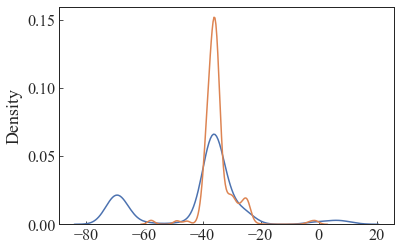

In [15]:
import seaborn as sns

sns.kdeplot(composite_phis)
sns.kdeplot(composite_phis_clipped)

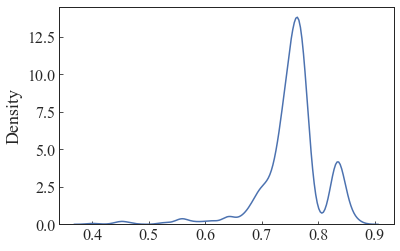

In [20]:
sns.kdeplot(composite_qs)

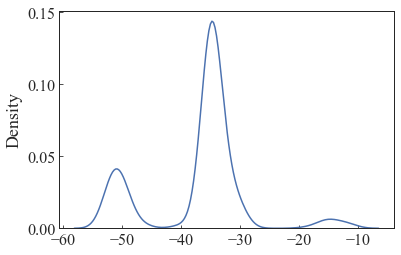

In [21]:
sns.kdeplot(composite_psi_exts)